<a href="https://colab.research.google.com/github/castillosebastian/willow/blob/main/Topic_Modeling_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Métodos no supervisados - topic modeling y clustering

## Setup<div class='tocSkip'/>

Setamos las ubicaciones de los directorios de la notebook original. Si no estás trabajando en Gooble Colab, bajá los archivoes e instalá las librerías.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
    os.system(f'wget {GIT_ROOT}/ch08/setup.py')

%run -i setup.py

You are working on Google Colab.
Files will be downloaded to "/content".
!wget -P /content https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/settings.py
!wget -P /content/data/un-general-debates https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/un-general-debates/un-general-debates-blueprint.csv.gz
!wget -P /content/ch08 https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/ch08/requirements.txt

Additional setup ...
!pip install -r ch08/requirements.txt


In [2]:
!pip install --upgrade numpy

## Cargá los seteos de python<div class="tocSkip"/>
Importa los seteos comunes de matplolib, pandas

In [3]:
#%run "$BASE_DIR/settings.py"

#%reload_ext autoreload
#%autoreload 2
#%config InlineBackend.figure_format = 'png'

# Cargamos el dataset de los debates en formato panda

In [4]:
import pandas as pd
df = pd.read_csv(DEBATES_FILE)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
dtypes: int64(2), object(5)
memory usage: 410.7+ KB


In [5]:
print(repr(df.iloc[0]["text"][0:200]))
print(repr(df.iloc[-1]["text"][0:200]))

'33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly?\n34.\tIn taking up the work '
'Allow me at the outset to extend to Mr. Mogens Lykketoft my warm congratulations on his election to the high office of President of the General Assembly at its seventieth session. He assumes this offi'


# Dividir y analizar

In [6]:
import re
df["paragraphs"] = df["text"].map(lambda text: re.split('\.\s*\n', text))
df["number_of_paragraphs"] = df["paragraphs"].map(len)

<Axes: xlabel='year'>

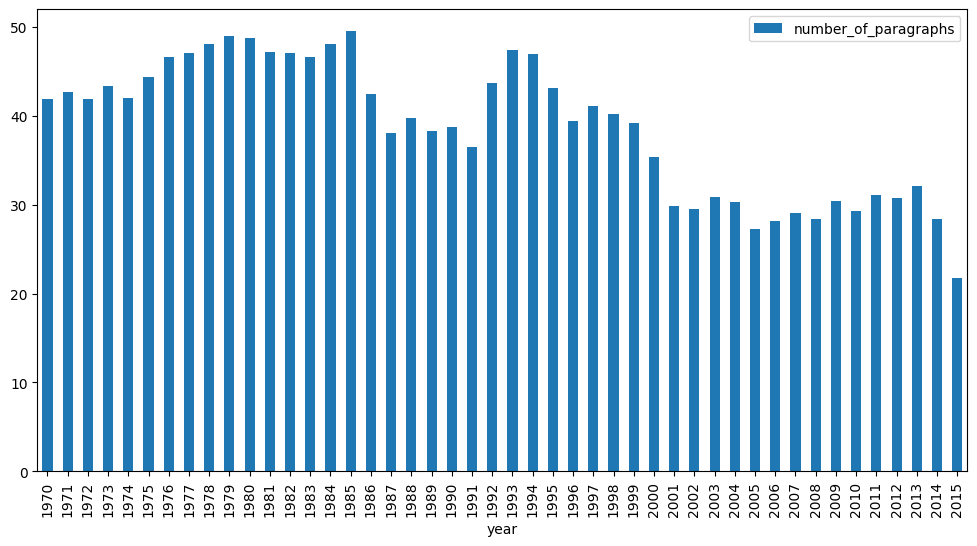

In [7]:
%matplotlib inline
df.groupby('year').agg({'number_of_paragraphs': 'mean'}).plot.bar(figsize=(12,6))

In [8]:
#pip install --upgrade scikit-learn numpy


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
import spacy
from spacy.lang.en.examples import sentences
en = spacy.load("en_core_web_sm")
#en = spacy.load("en_core_web_lg")
stopwords = en.Defaults.stop_words
print(stopwords)

{'five', "'re", 'why', 'without', 'being', 'meanwhile', 'six', 'after', 'during', 'any', 'whereas', 'there', 'himself', 'these', 'done', 'were', 'further', 'we', 'used', 'that', 'i', 'here', 'should', 'everyone', 'where', 'at', 'sometimes', 'wherein', 'forty', 'n‘t', 'she', 'move', "'m", 'could', 'mine', 'what', 'alone', '’m', 'around', 'nobody', 'him', 'whole', 'nothing', 'may', 'due', 'towards', 'part', 'both', 'top', 'whether', 'toward', 'get', 'this', 'thereby', 'together', 'few', 'does', 'not', 'myself', 'whereafter', "'ll", 'am', 'ourselves', 'whence', 'nowhere', 'others', 'very', 'thereafter', 'itself', 'once', 'fifty', 'thence', 'neither', 'wherever', '‘m', "'ve", 'and', 'indeed', '‘s', 'formerly', 'hereby', 'it', 'other', 'seems', 'is', 'made', 'each', 'between', 'yourselves', 'front', 'hereupon', 'out', 'was', 'everything', 'who', 'a', 'eight', 'which', 'thereupon', 'already', '’s', 'say', '’d', 'except', 'three', 'whose', 'doing', 'the', 'something', 'before', 'whom', 'n’t',

In [11]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(7507, 24611)

In [12]:
# flatten the paragraphs keeping the years
paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year }
                               for paragraphs, year in zip(df["paragraphs"], df["year"])
                                    for paragraph in paragraphs if paragraph])

In [13]:
tfidf_para_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["text"])
tfidf_para_vectors.shape

(279076, 25162)

# NMF

## Discuros

In [14]:
from sklearn.decomposition import NMF

nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [15]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [16]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  co (0.79)
  operation (0.65)
  disarmament (0.36)
  nuclear (0.34)
  relations (0.25)

Topic 01
  terrorism (0.38)
  challenges (0.32)
  sustainable (0.30)
  millennium (0.29)
  reform (0.28)

Topic 02
  africa (1.15)
  african (0.82)
  south (0.63)
  namibia (0.36)
  delegation (0.30)

Topic 03
  arab (1.02)
  israel (0.89)
  palestinian (0.60)
  lebanon (0.54)
  israeli (0.54)

Topic 04
  american (0.33)
  america (0.31)
  latin (0.31)
  panama (0.21)
  bolivia (0.21)

Topic 05
  pacific (1.55)
  islands (1.23)
  solomon (0.86)
  island (0.82)
  fiji (0.71)

Topic 06
  soviet (0.81)
  republic (0.78)
  nuclear (0.68)
  viet (0.64)
  socialist (0.63)

Topic 07
  guinea (4.26)
  equatorial (1.75)
  bissau (1.53)
  papua (1.47)
  republic (0.57)

Topic 08
  european (0.61)
  europe (0.44)
  cooperation (0.39)
  bosnia (0.34)
  herzegovina (0.30)

Topic 09
  caribbean (0.98)
  small (0.66)
  bahamas (0.63)
  saint (0.63)
  barbados (0.61)


In [17]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([11.06189432, 17.0213082 , 13.6565622 , 10.18695452, 11.35821532,
        5.95003141,  7.90001101,  4.13937503, 11.91132462,  6.81432338])

## Parrafos

In [18]:
nmf_para_model = NMF(n_components=10, random_state=42)
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_

In [19]:
display_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())


Topic 00
  nations (5.61)
  united (5.50)
  organization (1.27)
  states (1.02)
  charter (0.93)

Topic 01
  general (2.86)
  session (2.83)
  assembly (2.81)
  mr (1.99)
  president (1.81)

Topic 02
  countries (4.41)
  developing (2.49)
  economic (1.50)
  developed (1.35)
  trade (0.92)

Topic 03
  people (1.36)
  peace (1.33)
  east (1.29)
  middle (1.17)
  palestinian (1.16)

Topic 04
  nuclear (4.93)
  weapons (3.26)
  disarmament (2.01)
  treaty (1.71)
  proliferation (1.46)

Topic 05
  rights (6.48)
  human (6.16)
  respect (1.15)
  fundamental (0.85)
  universal (0.82)

Topic 06
  africa (3.80)
  south (3.30)
  african (1.70)
  namibia (1.38)
  apartheid (1.18)

Topic 07
  security (6.10)
  council (5.87)
  permanent (1.49)
  reform (1.49)
  peace (1.29)

Topic 08
  international (2.03)
  world (1.48)
  community (0.91)
  new (0.76)
  peace (0.67)

Topic 09
  development (4.47)
  sustainable (1.19)
  economic (1.06)
  social (0.99)
  goals (0.94)


In [20]:
W_para_matrix.sum(axis=0)/W_para_matrix.sum()*100.0

array([10.42905814, 10.3250673 , 10.19143368,  9.97207971,  6.63847604,
        7.36011502,  8.92422143,  8.31107274, 16.87412537, 10.97435057])

# TruncatedSVD

In [21]:
from sklearn.decomposition import TruncatedSVD

svd_para_model = TruncatedSVD(n_components = 10, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_para_vectors)
H_svd_para_matrix = svd_para_model.components_

In [22]:
display_topics(svd_para_model, tfidf_para_vectorizer.get_feature_names_out())


Topic 00
  nations (0.67)
  united (0.65)
  international (0.58)
  peace (0.46)
  world (0.46)

Topic 01
  general (14.25)
  assembly (13.32)
  session (13.19)
  mr (10.22)
  president (8.76)

Topic 02
  countries (20.95)
  development (16.12)
  economic (15.29)
  developing (14.28)
  session (11.14)

Topic 03
  nations (4.43)
  united (4.07)
  development (0.93)
  organization (0.85)
  charter (0.81)

Topic 04
  nuclear (20.20)
  weapons (13.39)
  disarmament (8.64)
  treaty (6.93)
  proliferation (6.06)

Topic 05
  rights (28.41)
  human (27.71)
  nuclear (8.64)
  weapons (6.05)
  respect (4.81)

Topic 06
  africa (9.02)
  south (8.42)
  united (3.91)
  african (3.89)
  namibia (3.56)

Topic 07
  council (14.36)
  security (13.05)
  africa (7.88)
  south (5.65)
  reform (3.77)

Topic 08
  world (39.38)
  peace (29.97)
  international (28.78)
  africa (18.09)
  new (16.47)

Topic 09
  development (59.33)
  sustainable (19.32)
  peace (16.94)
  goals (14.87)
  africa (12.88)


In [23]:
svd_para_model.singular_values_

array([71.58542396, 39.32344616, 36.48183715, 34.81530053, 33.26015445,
       31.44496673, 29.85898267, 28.66414412, 26.99316039, 26.7319264 ])

# LDA

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])
count_para_vectors.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(279076, 25162)

In [25]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

In [26]:
display_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())


Topic 00
  general (4.46)
  assembly (3.55)
  session (3.09)
  president (2.12)
  mr (1.91)

Topic 01
  world (2.60)
  human (1.17)
  people (0.92)
  peace (0.80)
  nations (0.72)

Topic 02
  nuclear (2.88)
  weapons (2.13)
  disarmament (1.67)
  arms (1.39)
  states (1.23)

Topic 03
  international (2.36)
  security (2.18)
  united (2.02)
  nations (2.01)
  council (1.95)

Topic 04
  countries (4.60)
  economic (2.86)
  developing (2.01)
  development (1.51)
  international (1.46)

Topic 05
  peace (2.13)
  east (1.43)
  middle (1.34)
  people (1.31)
  israel (1.24)

Topic 06
  states (1.77)
  countries (1.45)
  peace (1.23)
  relations (1.22)
  peoples (1.19)

Topic 07
  africa (3.06)
  south (2.04)
  united (1.83)
  nations (1.58)
  african (1.04)

Topic 08
  people (1.80)
  republic (1.50)
  government (1.41)
  united (1.26)
  nations (1.04)

Topic 09
  nations (3.25)
  united (2.91)
  development (2.33)
  international (1.69)
  world (1.13)


In [27]:
W_lda_para_matrix.sum(axis=0)/W_lda_para_matrix.sum()*100.0

array([ 8.96413708, 13.1939403 ,  7.04455321, 11.08311812,  9.84055263,
        8.80334442,  8.89408336,  6.94897733,  9.48290182, 15.74439172])

In [28]:
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()




In [29]:

pyLDAvis.lda_model.prepare(lda_para_model, count_para_vectors, count_para_vectorizer, sort_topics=False)
#pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.321600  0.015162       1        1   7.443777
1      0.096747  0.057745       2        1  12.799428
2      0.034976  0.044819       3        1   7.580510
3     -0.038928  0.001285       4        1  10.963884
4      0.099396  0.179533       5        1  10.527439
5      0.101858 -0.142437       6        1   9.094568
6      0.054713 -0.064996       7        1   9.387952
7      0.049526 -0.108920       8        1   7.571069
8     -0.053274 -0.127350       9        1   9.623224
9     -0.023413  0.145158      10        1  15.008150, topic_info=            Term          Freq         Total Category  logprob  loglift
10206    general  52281.000000  52281.000000  Default  30.0000  30.0000
5823   countries  86378.000000  86378.000000  Default  29.0000  29.0000
2472    assembly  40205.000000  40205.000000  Default  28.0000  28.0000
15686    nuclear  22870.000000  22870.000000  Default  27.0000  27.0000
20488    session  29239.000000  29239.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
21043     social   6301.657320  21290.585465  Topic10  -5.5190   0.6791
16657      peace   7616.746601  77528.101584  Topic10  -5.3295  -0.4237
20322   security   6930.230799  58096.637956  Topic10  -5.4240  -0.2296
25065       year   5816.757010  23476.748357  Topic10  -5.5991   0.5013
5823   countries   6430.110200  86378.851980  Topic10  -5.4989  -0.7012

[826 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
52         4  0.985936  1244
67         4  0.993490  1325
75         4  0.994528  1373
286        6  0.999709  1967
349        2  0.000742  2015
...      ...       ...   ...
25151      3  0.696840  zone
25151      5  0.002319  zone
25151      6  0.004639  zone
25151      7  0.238907  zone
25151      9  0.056993  zone

[2771 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [30]:
lda_tsne_display = pyLDAvis.lda_model.prepare(lda_para_model, count_para_vectors, count_para_vectorizer, sort_topics=False, mds='tsne')
pyLDAvis.display(lda_tsne_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Mostrar modelos de topicos en nubes de palabras

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength i

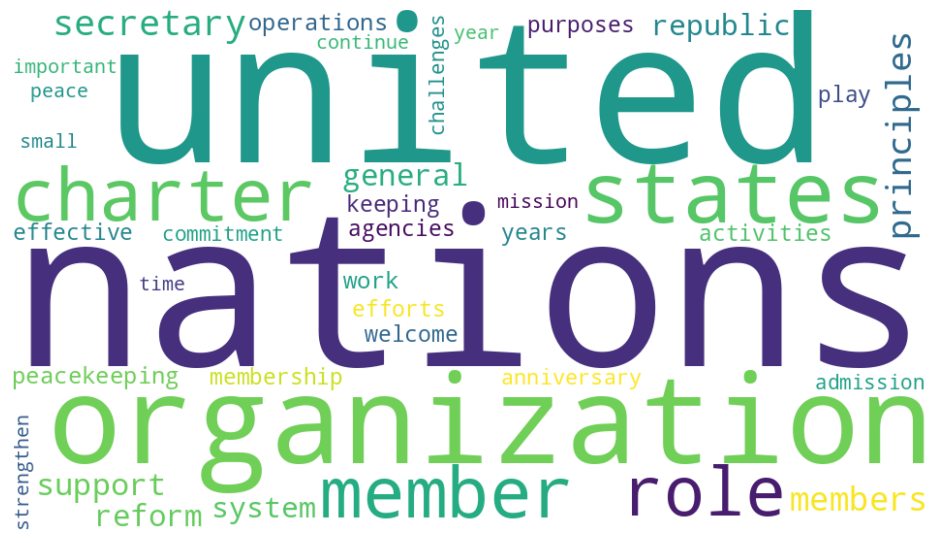

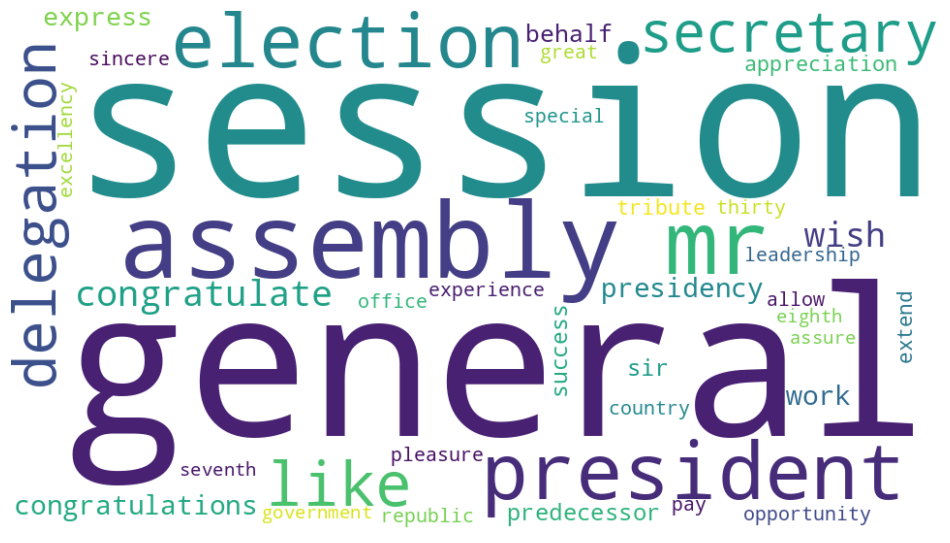

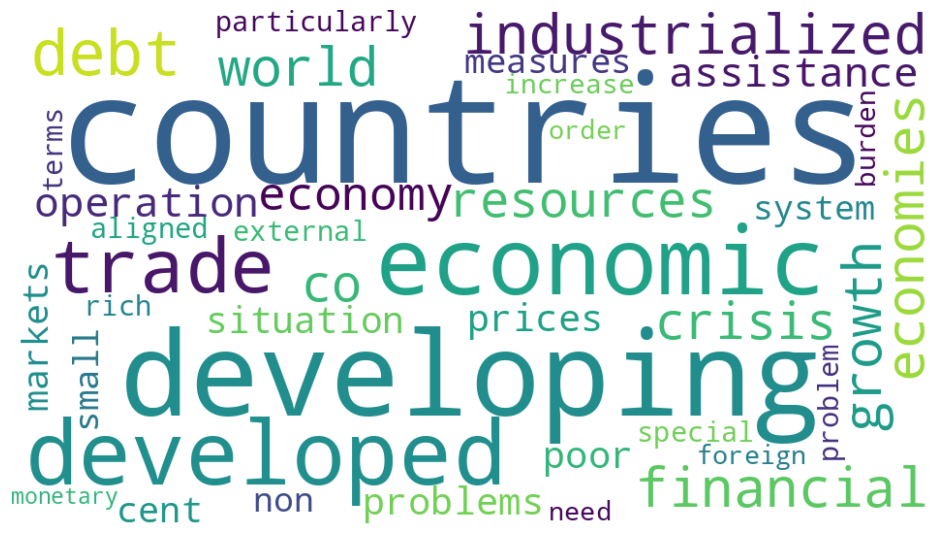

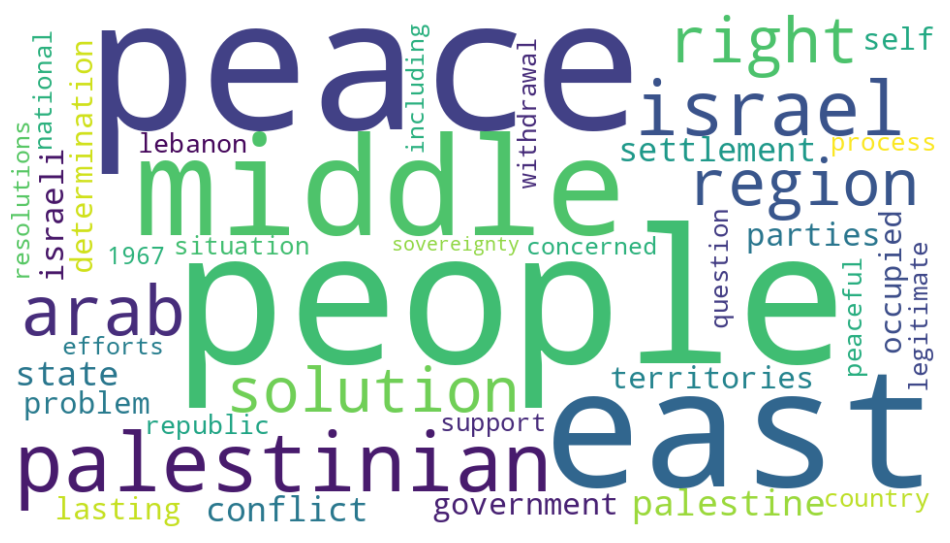

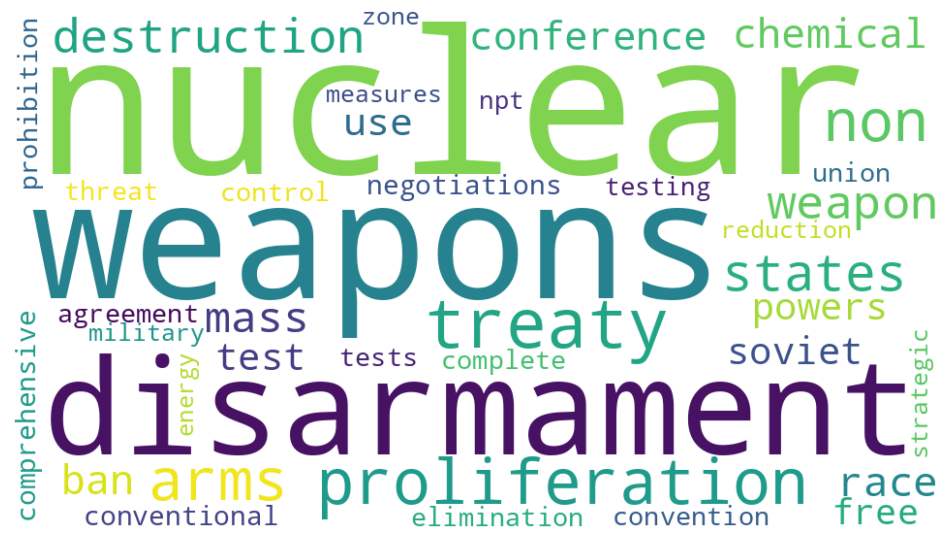

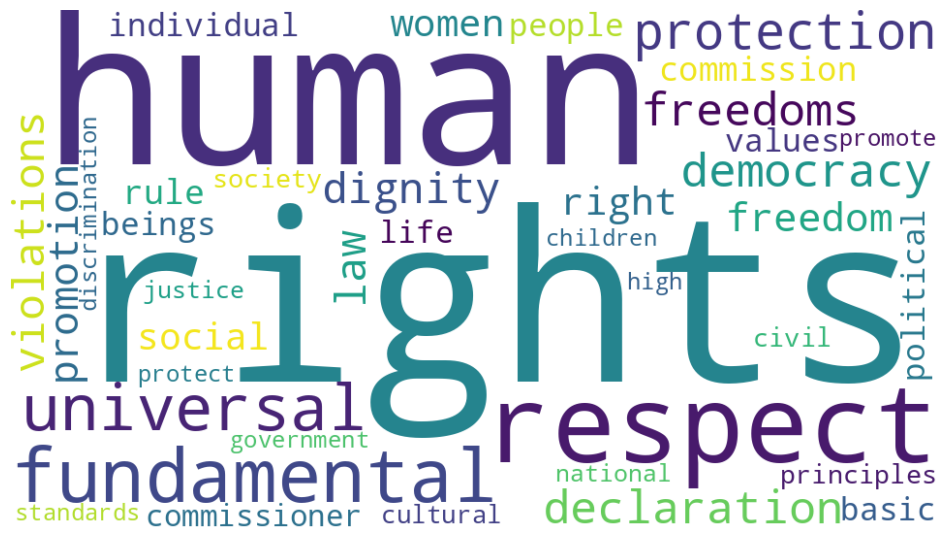

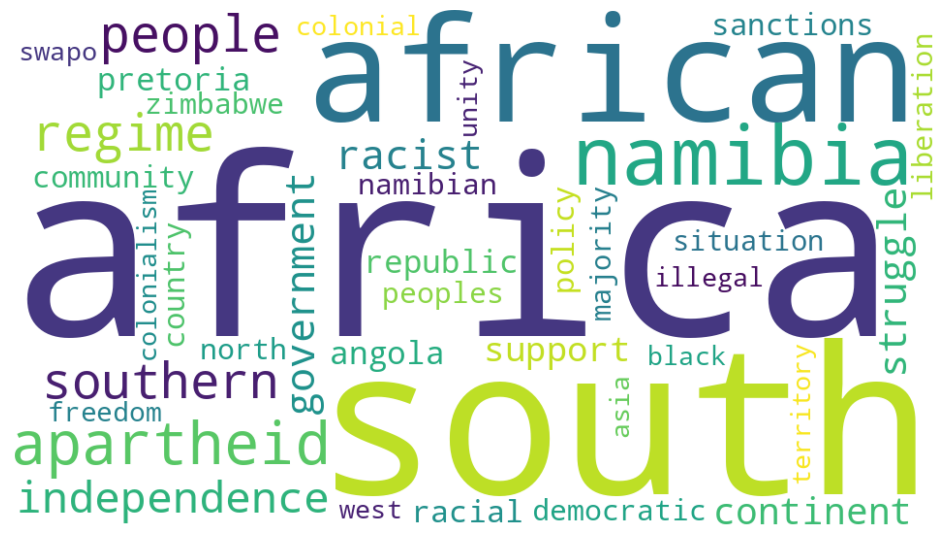

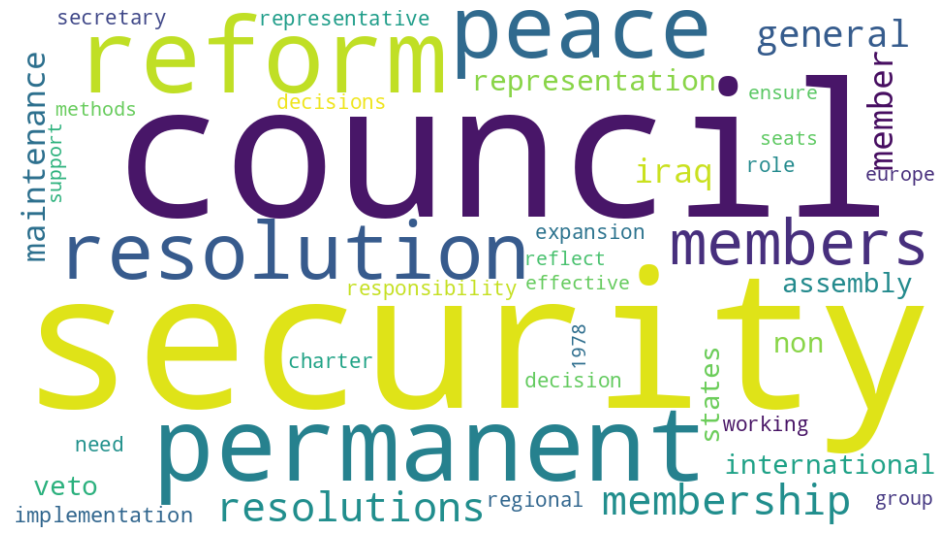

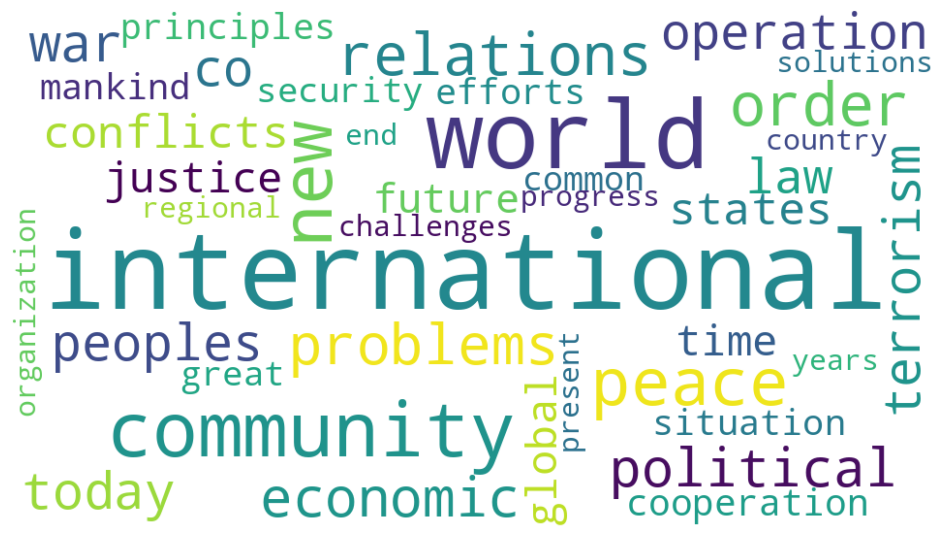

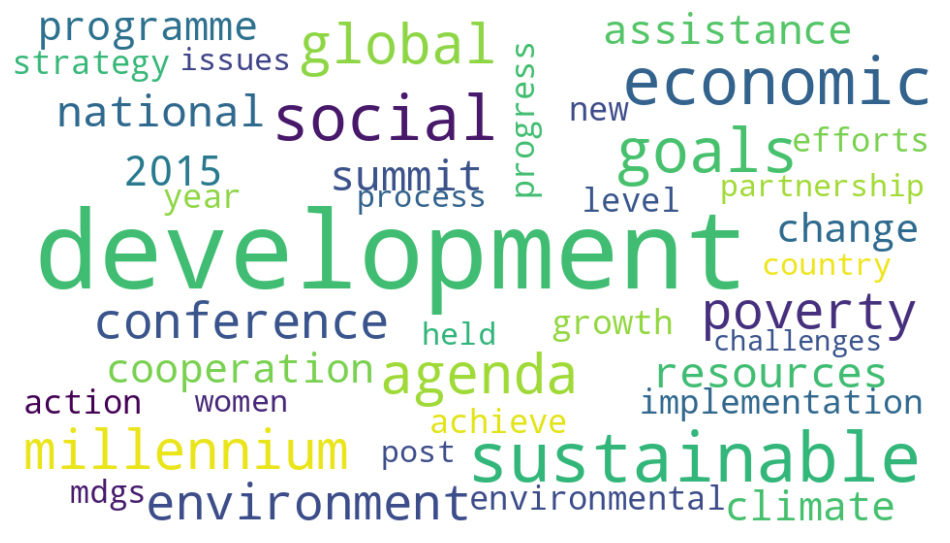

In [32]:
wordcloud_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength i

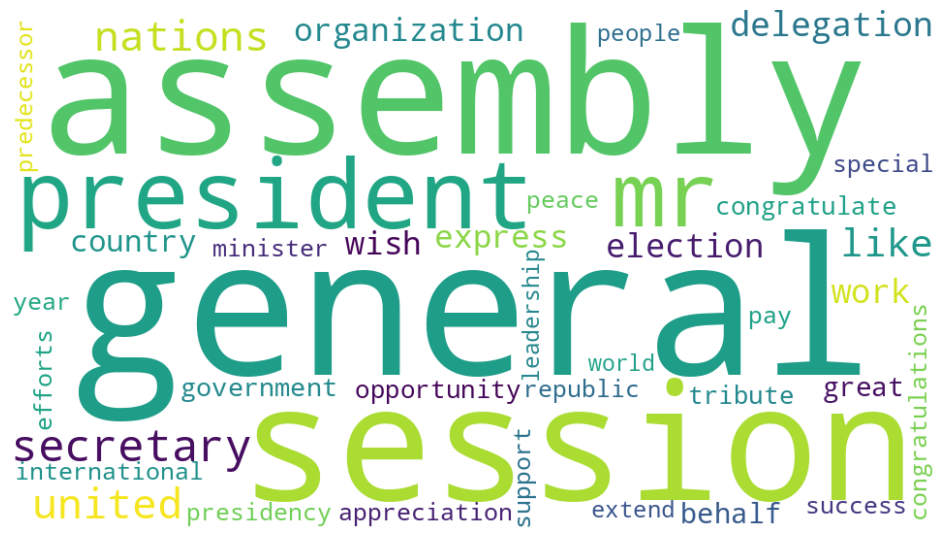

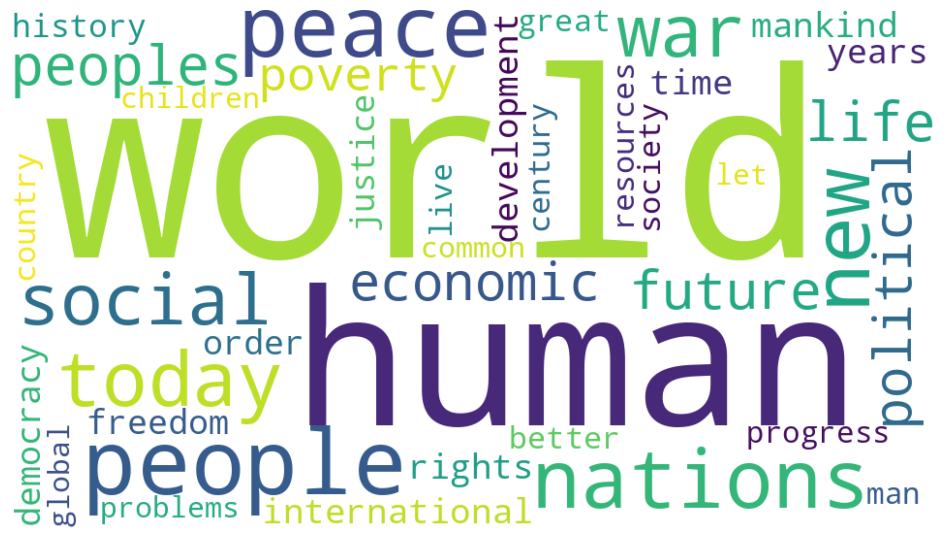

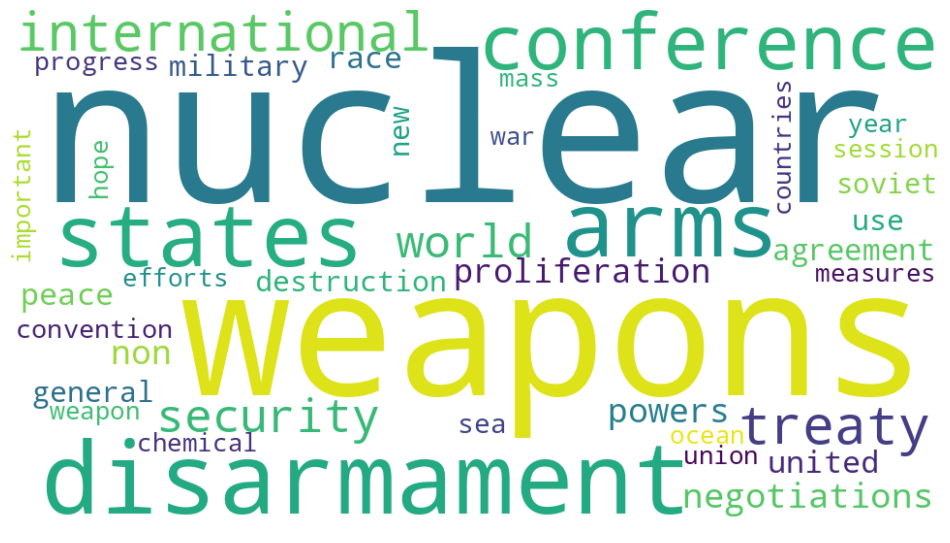

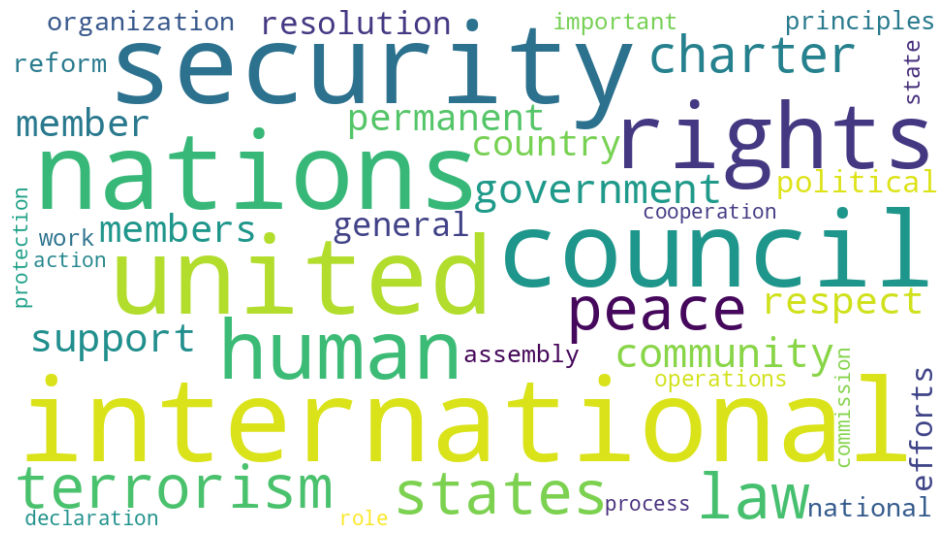

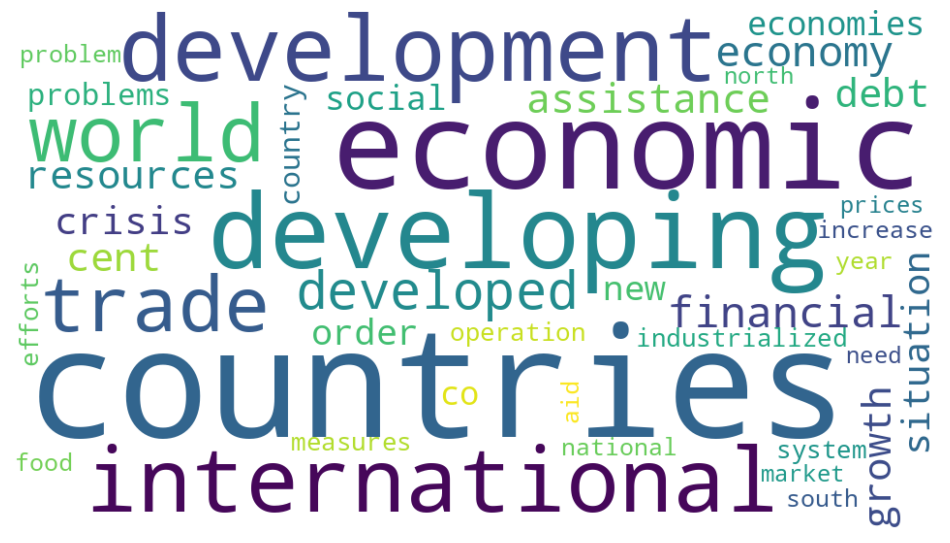

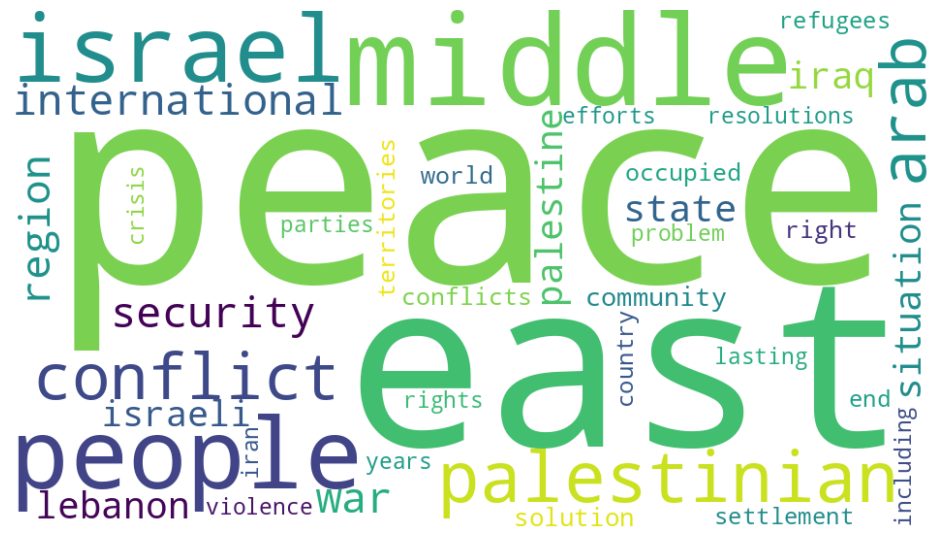

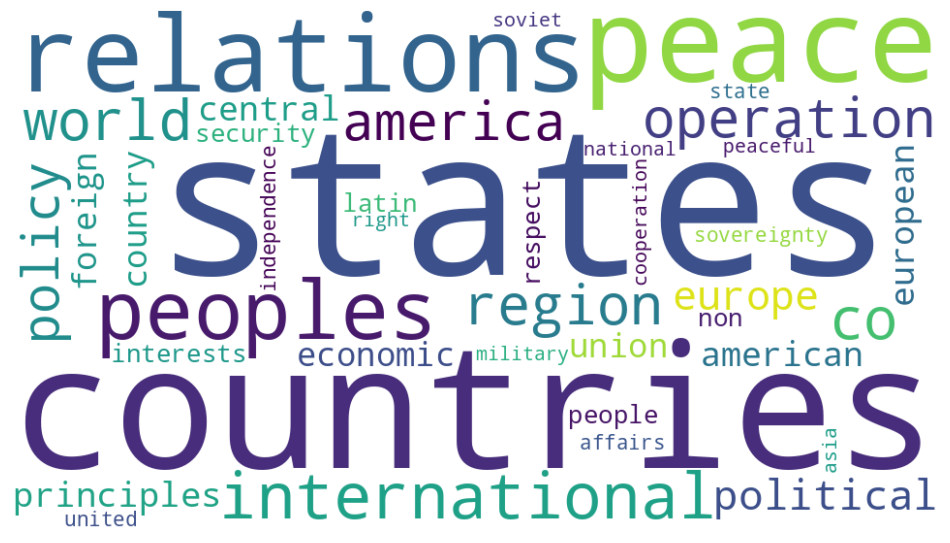

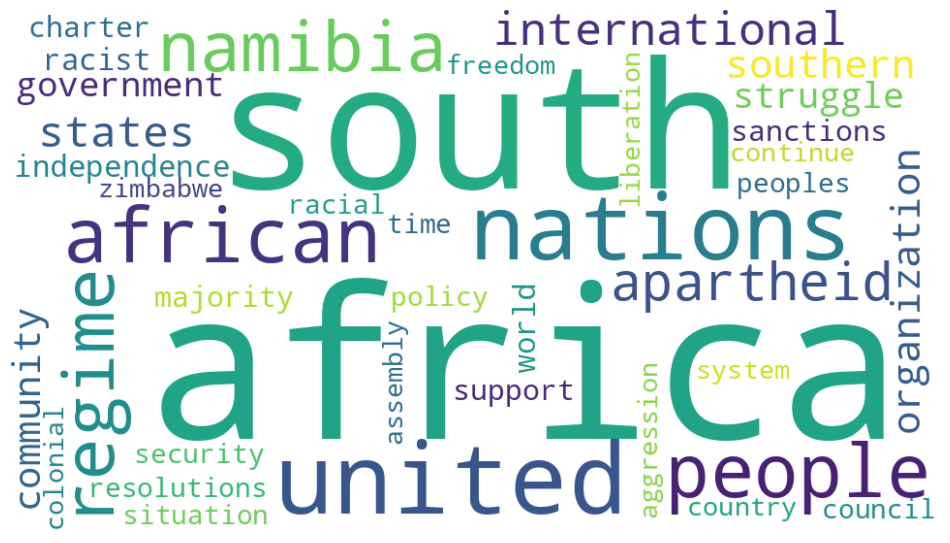

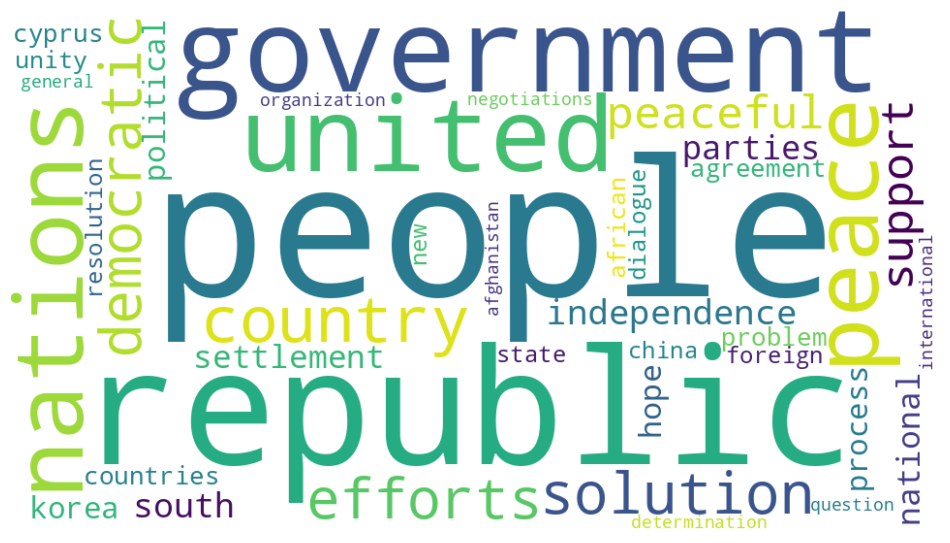

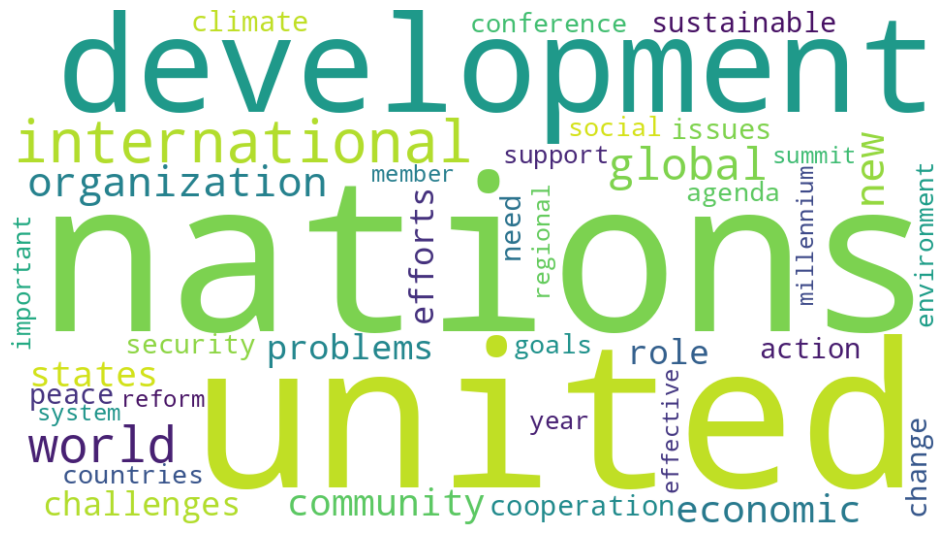

In [33]:
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())

# Evolución de tópicos a través del tiempo

In [34]:
W_para_matrix.sum(axis=0)/W_para_matrix.sum()*100.0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([10.42905814, 10.3250673 , 10.19143368,  9.97207971,  6.63847604,
        7.36011502,  8.92422143,  8.31107274, 16.87412537, 10.97435057])

In [35]:
import numpy as np
before_1990 = np.array(paragraph_df["year"] < 1990)
after_1990 = ~ before_1990

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
W_para_matrix_early = nmf_para_model.transform(tfidf_para_vectors[before_1990])
W_para_matrix_late  = nmf_para_model.transform(tfidf_para_vectors[after_1990])
print(W_para_matrix_early.sum(axis=0)/W_para_matrix_early.sum()*100.0)
print(W_para_matrix_late.sum(axis=0)/W_para_matrix_late.sum()*100.0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[ 9.20962178 10.45479064 12.23762512 11.96923534  7.83419198  6.07025801
 12.22928118  5.87559699 17.43863725  6.68076171]
[11.40231656 10.22115968  8.55802537  8.38145136  5.68415097  8.38983684
  6.28414804 10.25571869 16.42180086 14.40139163]


In [37]:
['%1.2f'%x for x in W_para_matrix_early.sum(axis=0)/W_para_matrix_early.sum()*100.0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['9.21',
 '10.45',
 '12.24',
 '11.97',
 '7.83',
 '6.07',
 '12.23',
 '5.88',
 '17.44',
 '6.68']

In [38]:
['%1.2f'%x for x in W_para_matrix_early.sum(axis=0)/W_para_matrix_late.sum()*100.0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['7.35',
 '8.35',
 '9.77',
 '9.55',
 '6.25',
 '4.85',
 '9.76',
 '4.69',
 '13.92',
 '5.33']

In [39]:
from tqdm.auto import tqdm
import numpy as np
year_data = []
for year in tqdm(np.unique(np.unique(paragraph_df["year"]))):
    W_year = nmf_para_model.transform(tfidf_para_vectors[np.array(paragraph_df["year"] == year)])
    year_data.append([year] + list(W_year.sum(axis=0)/W_year.sum()*100.0))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/46 [00:00<?, ?it/s]

In [40]:
topic_names = []
voc = tfidf_para_vectorizer.get_feature_names_out()
for topic in nmf_para_model.components_:
    important = topic.argsort()
    top_word = voc[important[-1]] + " " + voc[important[-2]]
    topic_names.append("Topic " + top_word)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='year'>

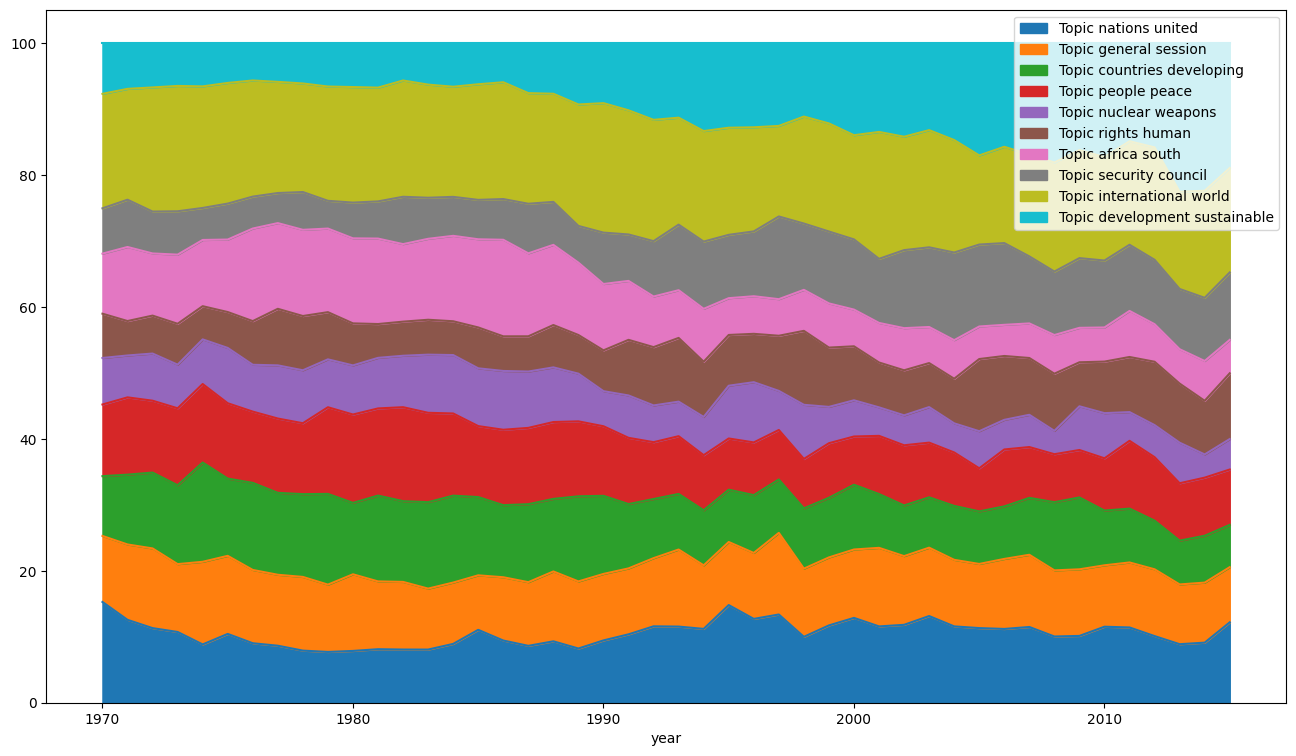

In [42]:
df_year = pd.DataFrame(year_data, columns=["year"] + topic_names).set_index("year")
df_year.plot.area(figsize=(16,9))

In [43]:
[f'Topic {count_para_vectorizer.get_feature_names_out()[words.argsort()[-1]]}' for words in nmf_para_model.components_]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Topic nations',
 'Topic general',
 'Topic countries',
 'Topic people',
 'Topic nuclear',
 'Topic rights',
 'Topic africa',
 'Topic security',
 'Topic international',
 'Topic development']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='year'>

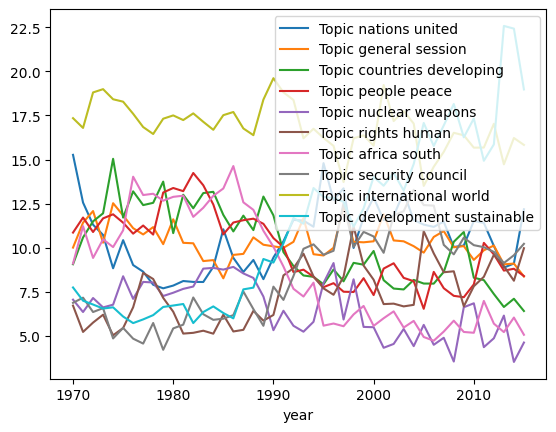

In [44]:
df_year.plot()

# Número óptimo de tópicos

In [45]:
#lda_para_model.perplexity(tfidf_para_vectors)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#from tqdm.auto import tqdm
#lda_para_model_n = []
for n in tqdm(range(5, 21)):
    lda_model = LatentDirichletAllocation(n_components = n, random_state=42)
    lda_model.fit_transform(count_para_vectors)
    lda_perplexity = lda_model.perplexity(tfidf_para_vectors)
    lda_para_model_n.append((lda_model, lda_perplexity))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
#lda_para_model_n

# Gensim

In [ ]:
# create tokenized documents
gensim_paragraphs = [[w for w in re.findall(r'\b\w\w+\b' , paragraph.lower()) if w not in stopwords]
                           for paragraph in paragraph_df["text"]]

In [ ]:
from gensim.corpora import Dictionary

dict_gensim_para = Dictionary(gensim_paragraphs)

In [ ]:
dict_gensim_para.filter_extremes(no_below=5, no_above=0.7)

In [ ]:
bow_gensim_para = [dict_gensim_para.doc2bow(paragraph) for paragraph in gensim_paragraphs]

In [ ]:
from gensim.models import TfidfModel
tfidf_gensim_para = TfidfModel(bow_gensim_para)
vectors_gensim_para = tfidf_gensim_para[bow_gensim_para]

## NMF

In [ ]:
from gensim.models.nmf import Nmf

nmf_gensim_para = Nmf(vectors_gensim_para, num_topics=10, id2word=dict_gensim_para, kappa=0.1, eval_every=5, random_state=42)

In [ ]:
def display_topics_gensim(model):
    for topic in range(0, model.num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=5):
            print("  %s (%2.2f)" % (word, prob))

In [ ]:
display_topics_gensim(nmf_gensim_para)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

nmf_gensim_para_coherence = CoherenceModel(model=nmf_gensim_para, texts=gensim_paragraphs, dictionary=dict_gensim_para, coherence='c_v')
nmf_gensim_para_coherence_score = nmf_gensim_para_coherence.get_coherence()
print(nmf_gensim_para_coherence_score)

## LDA

In [ ]:
from gensim.models import LdaModel
lda_gensim_para = LdaModel(corpus=bow_gensim_para, id2word=dict_gensim_para, chunksize=2000,
    alpha='auto', eta='auto', iterations=400, num_topics=10, passes=20, eval_every=None, random_state=42)

In [ ]:
display_topics_gensim(lda_gensim_para)

In [ ]:
lda_gensim_para.log_perplexity(vectors_gensim_para)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

lda_gensim_para_coherence = CoherenceModel(model=lda_gensim_para, texts=gensim_paragraphs, dictionary=dict_gensim_para, coherence='c_v')
lda_gensim_para_coherence_score = lda_gensim_para_coherence.get_coherence()
print(lda_gensim_para_coherence_score)

In [ ]:
print(lda_gensim_para_coherence_score)

In [ ]:
lda_gensim_para.alpha

In [ ]:
nmf_gensim_para_coherence = CoherenceModel(model=nmf_gensim_para, texts=gensim_paragraphs, dictionary=dict_gensim_para, coherence='c_v')
nmf_gensim_para_coherence_score = nmf_gensim_para_coherence.get_coherence()
print(nmf_gensim_para_coherence_score)

In [ ]:
top_topics = lda_gensim_para.top_topics(vectors_gensim_para, topn=5)
avg_topic_coherence = sum([t[1] for t in top_topics]) / len(top_topics)
print('Average topic coherence: %.4f.' % avg_topic_coherence)

In [ ]:
[(t[1], " ".join([w[1] for w in t[0]])) for t in top_topics]

## Optimizar nro. de tópicos para LDA

In [ ]:
from gensim.models.ldamulticore import LdaMulticore
lda_para_model_n = []
for n in tqdm(range(5, 21)):
    lda_model = LdaMulticore(corpus=bow_gensim_para, id2word=dict_gensim_para, chunksize=2000,
                             eta='auto', iterations=400, num_topics=n, passes=20,
                             eval_every=None, random_state=42)
    lda_coherence = CoherenceModel(model=lda_model, texts=gensim_paragraphs,
                                   dictionary=dict_gensim_para, coherence='c_v')
    lda_para_model_n.append((n, lda_model, lda_coherence.get_coherence()))

In [ ]:
pd.DataFrame(lda_para_model_n, columns=["n", "model", "coherence"]).set_index("n")[["coherence"]].plot(figsize=(16,9))

In [ ]:
display_topics_gensim(lda_para_model_n[12][1])

In [ ]:
def wordcloud_topics_gensim(model, no_top_words=40):
    for topic in range(0, model.num_topics):
        size = {}
        for (word, prob) in model.show_topic(topic, topn=no_top_words):
            size[word] = prob
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

In [ ]:
wordcloud_topics_gensim(lda_para_model_n[12][1])

## HDP

In [ ]:
from gensim.models import HdpModel
hdp_gensim_para = HdpModel(corpus=bow_gensim_para, id2word=dict_gensim_para)

In [ ]:
import re

In [ ]:
words = 8
pd.DataFrame([re.split(r" \+ |\*", t[1]) for t in hdp_gensim_para.print_topics(num_topics=20, num_words=words)])

In [ ]:
pd.set_option('max_colwidth', 1000)
pd.DataFrame(hdp_gensim_para.print_topics(num_topics=40, num_words=10), columns=["topic", "words"]).set_index("topic")

In [ ]:
hdp_gensim_para.show_topic(0, topn=10)

In [ ]:
def display_topics_gensim_hdp(model, num_topics):
    for topic in range(0, num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=10):
            print("  %s (%2.2f)" % (word, prob))

In [ ]:
display_topics_gensim_hdp(hdp_gensim_para, 50)

# Clustering

In [ ]:
from sklearn.cluster import KMeans
k_means_para = KMeans(n_clusters=10, random_state=42)
k_means_para.fit(tfidf_para_vectors)

In [ ]:
sizes = []
for i in range(10):
    sizes.append({"cluster": i, "size": np.sum(k_means_para.labels_==i)})
pd.DataFrame(sizes).set_index("cluster").plot.bar(figsize=(16,9))

In [ ]:
np.unique(k_means_para.labels_, return_counts=True)

In [ ]:
def wordcloud_clusters(model, vectors, features, no_top_words=40):
    for cluster in np.unique(model.labels_):
        size = {}
        words = vectors[model.labels_ == cluster].sum(axis=0).A[0]
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'cluster{cluster}.png')

In [ ]:
wordcloud_clusters(k_means_para, tfidf_para_vectors, tfidf_para_vectorizer.get_feature_names_out())